# Pré-traitement des données

## Chargement des données

In [1]:
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, GlobalMaxPool1D, Bidirectional
from keras.models import Model

from tools import *

Using TensorFlow backend.


In [2]:
# load raw string data
data_train, y_train_all, data_test, id_test = load_data()

## Nettoyage des données (optionnel)

In [3]:
comment = data_train[0]
print(comment)
print('-------')
print(clean_comment(comment))

Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27
-------
explanation edit make username hardcore metallica fan revert vandalisms closure gas vote new york dolls fac please remove template talk page since i m retire 


In [4]:
clean_data_train = transform_dataset(data_train, func=clean_comment)
clean_data_test = transform_dataset(data_test, func=clean_comment)

Transformation: 100%       
Transformation: 100%       


## Conversion numérique des données textuelles

In [13]:
# Convert strings to int indexes, 
# considering only the VOCAB_SIZE most commons words, 
# and pad the sentences to SENTENCE_LENGTH words
VOCAB_SIZE = 30000
SENTENCE_LENGTH = 120  # 200 if not cleaned, 120 otherwise

tokens_vectorizer = TokenVectorizer(max_len=SENTENCE_LENGTH, max_features=VOCAB_SIZE)

# X_train_all, X_test = encode(data_train, data_test, vectorizer=tokens_vectorizer)
X_train_all, X_test = encode(clean_data_train, clean_data_test, vectorizer=tokens_vectorizer)

ENCODING: Fitting vectorizer to data
ENCODING: transforming data to numerical


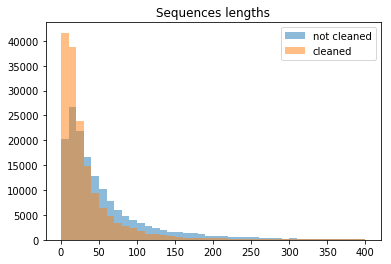

In [24]:
# how to set SENTENCE_LENGTH ?
import matplotlib.pyplot as plt
%matplotlib inline

seq_lengths = [len(comment.split()) for comment in data_train]
cleaned_seq_lengths = [len(comment.split()) for comment in clean_data_train]
hist_bins = np.arange(0,410,10)

plt.hist(seq_lengths, bins=hist_bins, alpha=0.5, label='not cleaned')
plt.hist(cleaned_seq_lengths, bins=hist_bins, alpha=0.5, label='cleaned')
# plt.hist([seq_lengths, cleaned_seq_lengths], bins=hist_bins, label=['not cleaned', 'cleaned'])
plt.legend(loc='upper right')
plt.title("Sequences lengths")
plt.show()

## Séparation du jeu d'entraînement et de validation

In [16]:
SPLIT_VALID_RATIO = 0.10
SPLIT_RANDOM_SEED = 0  # TODO : check split because of unbalanced classes

X_train, X_valid, y_train, y_valid = train_test_split(X_train_all, y_train_all, 
                                                      test_size=SPLIT_VALID_RATIO,
                                                      random_state=SPLIT_RANDOM_SEED)

# Test des différents modèles

## Embeddings + LSTM + 2 fc

In [17]:
EMBEDDING_DIM = 150
MODEL_NAME = "cleaned_embed_bidirlstm_2fc"

# input
inp = Input(shape=(SENTENCE_LENGTH, ))
# embedding
x = Embedding(VOCAB_SIZE, EMBEDDING_DIM)(inp)
# LSTM
x = Bidirectional(LSTM(60, return_sequences=True,name='lstm_layer'))(x)
# max pooling 1D
x = GlobalMaxPool1D()(x)
# dropout 1
x = Dropout(0.1)(x)
# dense 1
x = Dense(50, activation="relu")(x)
# dropout 2
x = Dropout(0.1)(x)
# dense 1
outp = Dense(6, activation="sigmoid")(x)

# # load pre-trained model from disk
# model = load_nnet(MODEL_NAME)

model = Model(inputs=inp, outputs=outp)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [18]:
# train
BATCH_SIZE = 32
N_EPOCHS = 2

RocAuc = RocAucEvaluation(validation_data=(X_valid, y_valid))

hist = model.fit(X_train, y_train, 
                 batch_size=BATCH_SIZE, 
                 epochs=N_EPOCHS, 
                 validation_data=(X_valid, y_valid),
                 callbacks=[RocAuc])

# save trained nnet to disk for later use
save_nnet(model, MODEL_NAME)

Train on 143613 samples, validate on 15958 samples
Epoch 1/2
143613/143613 [==============================] - 1071s 7ms/step - loss: 0.0619 - acc: 0.9791 - val_loss: 0.0471 - val_acc: 0.9829
epoch: 1 - val_roc_auc: 0.9745
Epoch 2/2
143613/143613 [==============================] - 1050s 7ms/step - loss: 0.0434 - acc: 0.9832 - val_loss: 0.0455 - val_acc: 0.9832
epoch: 2 - val_roc_auc: 0.9813


In [19]:
# final model evaluation
y_train_pred = model.predict(X_train, batch_size=512)
train_score = evaluate(y_train, y_train_pred)
print("ROC-AUC score on train set : {:.4f}".format(train_score)) 
                             
y_valid_pred = model.predict(X_valid, batch_size=512)
valid_score = evaluate(y_valid, y_valid_pred)
print("ROC-AUC score on validation set : {:.4f}".format(valid_score))

ROC-AUC score on train set : 0.9911
ROC-AUC score on validation set : 0.9813


In [20]:
# predict
y_test_pred = model.predict(X_test, batch_size=512, verbose=2)

In [21]:
# write submission file
submission(y_test_pred, id_test, name=MODEL_NAME)

## Embeddings + conv1D + fc (Yoon Kim)

In [ ]:
# TODO